This notebook is adapted from [Stanford CS224](http://snap.stanford.edu/class/cs224w-2021/) by Jure Leskovec.

# Graph Convolutional Neural Networks

In this notebook, we will work to construct our own graph neural network using PyTorch Geometric (PyG) and then apply that model on two Open Graph Benchmark (OGB) datasets. These two datasets will be used to benchmark your model's performance on two different graph-based tasks: 1) node property prediction, predicting properties of single nodes and 2) graph property prediction, predicting properties of entire graphs or subgraphs.

we will load and inspect the Open Graph Benchmark (OGB) datasets by using the `ogb` package. OGB is a collection of realistic, large-scale, and diverse benchmark datasets for machine learning on graphs. The `ogb` package not only provides data loaders for each dataset but also model evaluators.

Lastly, we will build our own graph neural network using PyTorch Geometric. We will then train and evaluate our model on the OGB node property prediction and graph property prediction tasks.

In [6]:
import torch
import os
print("PyTorch has version {}".format(torch.__version__))

PyTorch has version 2.3.0+cu121


In [7]:
!pip install torch-geometric
!pip install ogb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 13.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.8/78.8 kB 2.7 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2

Download the necessary packages for PyG. Make sure that your version of torch matches the output from the cell above. In case of any issues, more information can be found on the [PyG's installation page](https://pytorch-geometric.readthedocs.io/en/latest/notes/installation.html).

In [8]:
from torch_geometric.datasets import TUDataset
import torch_geometric.transforms as T
from ogb.nodeproppred import PygNodePropPredDataset, Evaluator
import torch
import pandas as pd
import torch.nn.functional as F
print(torch.__version__)

# The PyG built-in GCNConv
from torch_geometric.nn import GCNConv


2.3.0+cu121


# 1) PyTorch Geometric (Datasets and Data)


PyTorch Geometric has two classes for storing and/or transforming graphs into tensor format. One is `torch_geometric.datasets`, which contains a variety of common graph datasets. Another is `torch_geometric.data`, which provides the data handling of graphs in PyTorch tensors.

In this section, we will learn how to use `torch_geometric.datasets` and `torch_geometric.data` together.

## PyG Datasets

The `torch_geometric.datasets` class has many common graph datasets. Here we will explore its usage through one example dataset.

In [9]:
enzymes_dataset = TUDataset(root='.', name='PROTEINS').shuffle()

Processing...
Done!


## Question 1: What is the number of classes and number of features in the ENZYMES dataset? (5 points)

In [10]:
print(f'Dataset: {enzymes_dataset}:')
print('======================')
print(f'Number of graphs: {len(enzymes_dataset)}')
print(f'Number of features: {enzymes_dataset.num_features}')
print(f'Number of classes: {enzymes_dataset.num_classes}')

print(enzymes_dataset.x[0])

Dataset: PROTEINS(1113):
Number of graphs: 1113
Number of features: 3
Number of classes: 2
tensor([1., 0., 0.])


## PyG Data

Each PyG dataset stores a list of `torch_geometric.data.Data` objects, where each `torch_geometric.data.Data` object represents a graph. We can easily get the `Data` object by indexing into the dataset.

For more information such as what is stored in the `Data` object, please refer to the [documentation](https://pytorch-geometric.readthedocs.io/en/latest/modules/data.html#torch_geometric.data.Data).

In [11]:
print(enzymes_dataset[0])
print('Graph with index {} has label {}'.format(200, enzymes_dataset[200].y.item()))
print('Graph with index {} has {} number of edges'.format(200, enzymes_dataset[200].edge_index.shape[1]))

Data(edge_index=[2, 12], x=[4, 3], y=[1])
Graph with index 200 has label 0
Graph with index 200 has 162 number of edges


# 3) GNN: Node Property Prediction

In this section we will build our first graph neural network using PyTorch Geometric. Then we will apply it to the task of node property prediction (node classification).

Specifically, we will use GCN as the foundation for your graph neural network ([Kipf et al. (2017)](https://arxiv.org/pdf/1609.02907.pdf)). To do so, we will work with PyG's built-in `GCNConv` layer.

## Load and Preprocess the Dataset

In [12]:
from torch_geometric.loader import DataLoader
demo_loader = DataLoader(enzymes_dataset[:4], batch_size=3, shuffle=False)

print(enzymes_dataset[0])
print(enzymes_dataset[1])

print(enzymes_dataset[2])
print(enzymes_dataset[3])
print('============')
for idx, batch in enumerate(demo_loader):
    print(batch, batch.ptr)
    print(batch.num_graphs)


Data(edge_index=[2, 12], x=[4, 3], y=[1])
Data(edge_index=[2, 142], x=[40, 3], y=[1])
Data(edge_index=[2, 78], x=[21, 3], y=[1])
Data(edge_index=[2, 848], x=[285, 3], y=[1])
DataBatch(edge_index=[2, 232], x=[65, 3], y=[3], batch=[65], ptr=[4]) tensor([ 0,  4, 44, 65])
3
DataBatch(edge_index=[2, 848], x=[285, 3], y=[1], batch=[285], ptr=[2]) tensor([  0, 285])
1


# Advanced Graph Batching

What happened internally on the dataloader?. Since individual graph have represeneted their connetcivity according to the number of nodes in them a link on the graph 0 could read like [[0],[1]]
another link on the graph 2 could have the very same connectivty. Howvere they are no inside the grap, and therefore represent a single connection on the agggeragted graph.

In [13]:
from torch_geometric.loader import DataLoader
demo_loader2 = DataLoader(enzymes_dataset, batch_size=32, shuffle=True)

for idx, batch in enumerate(demo_loader2):
    print(batch)
    print(batch.num_graphs)
    if idx > 20:
        break



DataBatch(edge_index=[2, 4818], x=[1267, 3], y=[32], batch=[1267], ptr=[33])
32
DataBatch(edge_index=[2, 4298], x=[1128, 3], y=[32], batch=[1128], ptr=[33])
32
DataBatch(edge_index=[2, 7450], x=[2087, 3], y=[32], batch=[2087], ptr=[33])
32
DataBatch(edge_index=[2, 3496], x=[931, 3], y=[32], batch=[931], ptr=[33])
32
DataBatch(edge_index=[2, 4014], x=[1110, 3], y=[32], batch=[1110], ptr=[33])
32
DataBatch(edge_index=[2, 4030], x=[1078, 3], y=[32], batch=[1078], ptr=[33])
32
DataBatch(edge_index=[2, 3934], x=[1037, 3], y=[32], batch=[1037], ptr=[33])
32
DataBatch(edge_index=[2, 5068], x=[1379, 3], y=[32], batch=[1379], ptr=[33])
32
DataBatch(edge_index=[2, 3362], x=[888, 3], y=[32], batch=[888], ptr=[33])
32
DataBatch(edge_index=[2, 3678], x=[962, 3], y=[32], batch=[962], ptr=[33])
32
DataBatch(edge_index=[2, 4638], x=[1236, 3], y=[32], batch=[1236], ptr=[33])
32
DataBatch(edge_index=[2, 5340], x=[1408, 3], y=[32], batch=[1408], ptr=[33])
32
DataBatch(edge_index=[2, 6022], x=[1654, 3], y

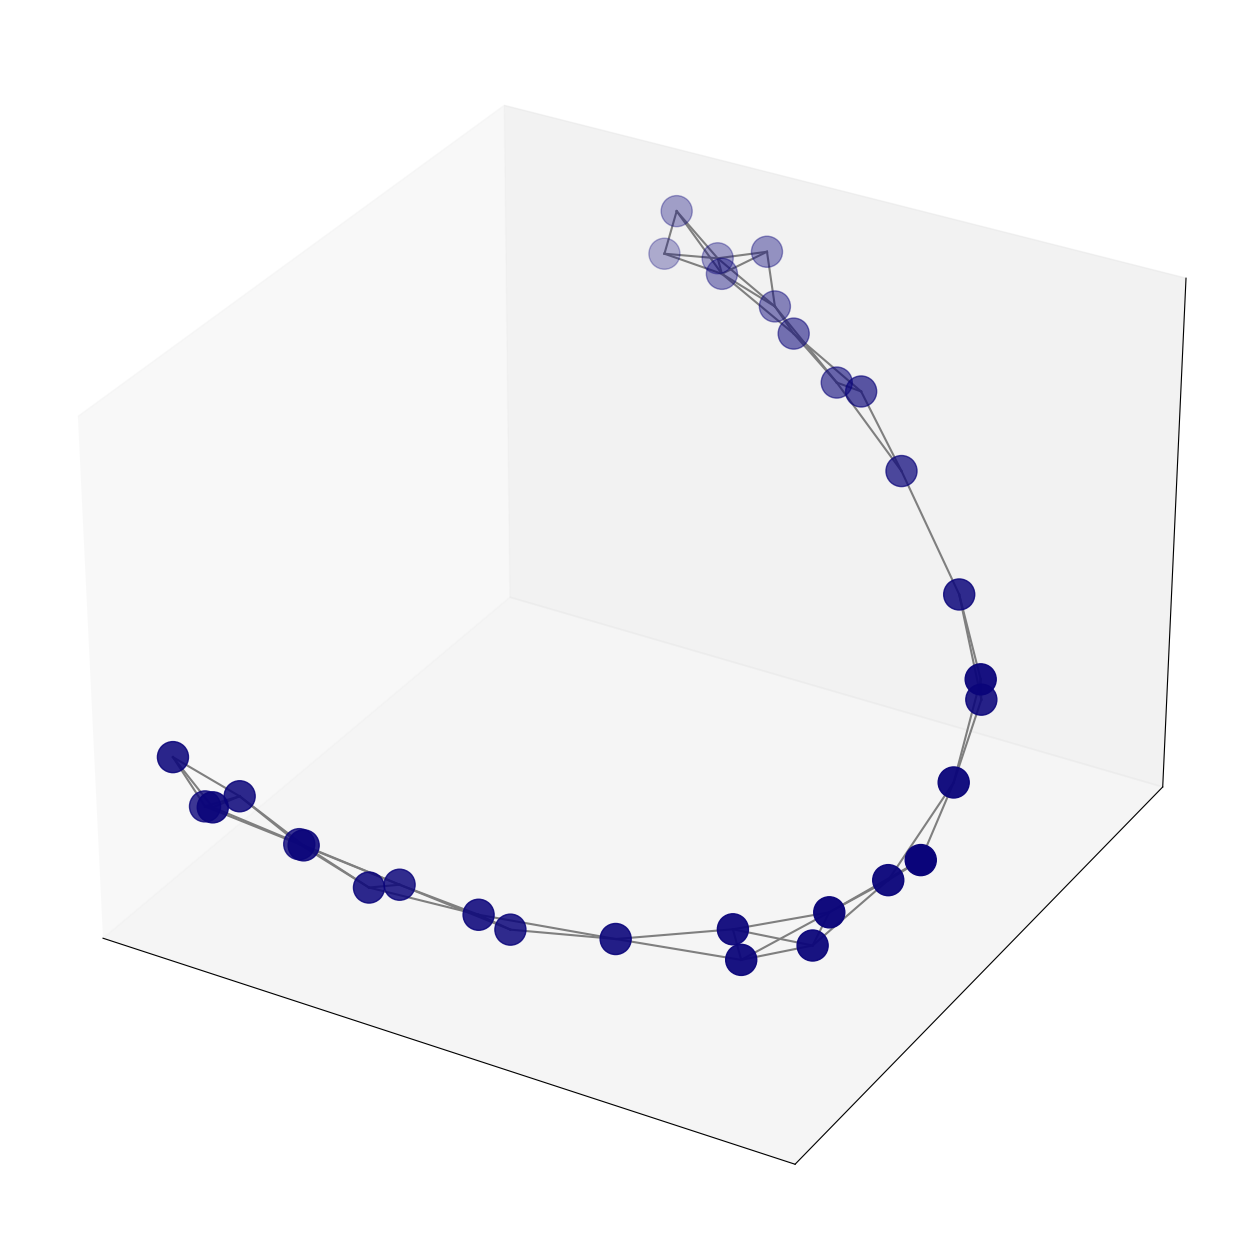

In [14]:
from torch_geometric.utils import to_networkx
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

import networkx as nx
import matplotlib.pyplot as plt

G = to_networkx(enzymes_dataset[35], to_undirected=True)

# 3D spring layout
pos = nx.spring_layout(G, dim=3, seed=0)

# Extract node and edge positions from the layout
node_xyz = np.array([pos[v] for v in sorted(G)])
edge_xyz = np.array([(pos[u], pos[v]) for u, v in G.edges()])

# Create the 3D figure
fig = plt.figure(figsize=(16,16))
ax = fig.add_subplot(111, projection="3d")

# Suppress tick labels
for dim in (ax.xaxis, ax.yaxis, ax.zaxis):
    dim.set_ticks([])

# Plot the nodes - alpha is scaled by "depth" automatically
ax.scatter(*node_xyz.T, s=500, c="#0A047A")

# Plot the edges
for vizedge in edge_xyz:
    ax.plot(*vizedge.T, color="tab:gray")

# fig.tight_layout()
plt.show()

In [15]:
from torch_geometric.loader import DataLoader

# Create training, validation, and test sets
train_idx = int(len(enzymes_dataset)*0.8)
train_dataset = enzymes_dataset[:train_idx]
val_dataset   = enzymes_dataset[train_idx:]

print(f'Training set   = {len(train_dataset)} graphs')
print(f'Validation set = {len(val_dataset)} graphs')

# Create mini-batches
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)

print('\nTrain loader:')
for i, subgraph in enumerate(train_loader):
    print(f' - Subgraph {i}: {subgraph}')

print('\nValidation loader:')
for i, subgraph in enumerate(val_loader):
    print(f' - Subgraph {i}: {subgraph}')


Training set   = 890 graphs
Validation set = 223 graphs

Train loader:
 - Subgraph 0: DataBatch(edge_index=[2, 5114], x=[1361, 3], y=[32], batch=[1361], ptr=[33])
 - Subgraph 1: DataBatch(edge_index=[2, 6344], x=[1681, 3], y=[32], batch=[1681], ptr=[33])
 - Subgraph 2: DataBatch(edge_index=[2, 3782], x=[983, 3], y=[32], batch=[983], ptr=[33])
 - Subgraph 3: DataBatch(edge_index=[2, 4380], x=[1151, 3], y=[32], batch=[1151], ptr=[33])
 - Subgraph 4: DataBatch(edge_index=[2, 4482], x=[1163, 3], y=[32], batch=[1163], ptr=[33])
 - Subgraph 5: DataBatch(edge_index=[2, 3862], x=[986, 3], y=[32], batch=[986], ptr=[33])
 - Subgraph 6: DataBatch(edge_index=[2, 3760], x=[1018, 3], y=[32], batch=[1018], ptr=[33])
 - Subgraph 7: DataBatch(edge_index=[2, 3490], x=[909, 3], y=[32], batch=[909], ptr=[33])
 - Subgraph 8: DataBatch(edge_index=[2, 4434], x=[1207, 3], y=[32], batch=[1207], ptr=[33])
 - Subgraph 9: DataBatch(edge_index=[2, 4446], x=[1245, 3], y=[32], batch=[1245], ptr=[33])
 - Subgraph 10:

## GCN Model

Now we will implement our GCN model!


In [16]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

import torch
import torch.nn.functional as F
from torch.nn import Linear, Sequential, BatchNorm1d, ReLU, Dropout
from torch_geometric.nn import GCNConv, GINConv
from torch_geometric.nn import global_mean_pool, global_add_pool


class EnzymesGCN(torch.nn.Module):
    """GCN"""
    def __init__(self, dim_h):
        super(EnzymesGCN, self).__init__()
        self.conv1 = GCNConv(train_dataset.num_node_features, dim_h)
        self.conv2 = GCNConv(dim_h, dim_h)
        self.conv3 = GCNConv(dim_h, dim_h)
        self.conv4 = GCNConv(dim_h, dim_h)
        self.conv5 = GCNConv(dim_h, dim_h)
        self.lin = Linear(dim_h, train_dataset.num_classes)

    def forward(self, x, edge_index, batch):
        # Node embeddings
        h = self.conv1(x, edge_index)
        h = h.relu()
        h = self.conv2(h, edge_index)
        h = h.relu()
        h = self.conv3(h, edge_index)
        h = h.relu()
        h = self.conv4(h, edge_index)
        h = h.relu()
        h = self.conv5(h, edge_index)
        h = h.relu()

        # Graph-level readout
        hG = global_mean_pool(h, batch)

        # Classifier
        h = F.dropout(hG, p=0.5, training=self.training)
        h = self.lin(h)

        return hG, F.log_softmax(h, dim=1)

print('GCN', EnzymesGCN)


class GIN(torch.nn.Module):
    """GIN"""
    def __init__(self, dim_h):
        super(GIN, self).__init__()
        self.conv1 = GINConv(
            Sequential(Linear(train_dataset.num_node_features, dim_h),
                       BatchNorm1d(dim_h), ReLU(),
                       Linear(dim_h, dim_h), ReLU()))
        self.conv2 = GINConv(
            Sequential(Linear(dim_h, dim_h), BatchNorm1d(dim_h), ReLU(),
                       Linear(dim_h, dim_h), ReLU()))
        self.conv3 = GINConv(
            Sequential(Linear(dim_h, dim_h), BatchNorm1d(dim_h), ReLU(),
                       Linear(dim_h, dim_h), ReLU()))
        self.lin1 = Linear(dim_h*3, dim_h*3)
        self.lin2 = Linear(dim_h*3, train_dataset.num_classes)

    def forward(self, x, edge_index, batch):
        # Node embeddings
        h1 = self.conv1(x, edge_index)
        h2 = self.conv2(h1, edge_index)
        h3 = self.conv3(h2, edge_index)

        # Graph-level readout
        h1 = global_add_pool(h1, batch)
        h2 = global_add_pool(h2, batch)
        h3 = global_add_pool(h3, batch)

        # Concatenate graph embeddings
        h = torch.cat((h1, h2, h3), dim=1)

        # Classifier
        h = self.lin1(h)
        h = h.relu()
        h = F.dropout(h, p=0.5, training=self.training)
        h = self.lin2(h)

        return h, F.log_softmax(h, dim=1)

GCN <class '__main__.EnzymesGCN'>


In [17]:
def train(model, train_loader, val_loader):
    print('Train')
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=0.1, weight_decay=0.01)
    epochs = 100


    for epoch in range(epochs+1):
        print('epoch', epoch)

        total_loss = 0
        acc = 0
        val_loss = 0
        val_acc = 0

        # Train on batches
        model.train()
        for data in train_loader:

            optimizer.zero_grad()
            _, out = model(data.x, data.edge_index, data.batch)
            loss = criterion(out, data.y)
            print(loss)
            total_loss += loss / len(train_loader)
            acc += accuracy(out.argmax(dim=1), data.y) / len(train_loader)
            loss.backward()
            optimizer.step()

        # Validation
        val_loss, val_acc = test(model, val_loader)

        # Print metrics every 10 epochs
        print(f'Epoch {epoch:>3} | Train Loss: {total_loss:.2f} '
              f'| Train Acc: {acc*100:>5.2f}% '
              f'| Val Loss: {val_loss:.2f} '
              f'| Val Acc: {val_acc*100:.2f}%')

    return model


def test(model, loader):
    criterion = torch.nn.CrossEntropyLoss()
    model.eval()
    loss = 0
    acc = 0

    for data in loader:
        _, out = model(data.x, data.edge_index, data.batch)
        loss += criterion(out, data.y) / len(loader)
        acc += accuracy(out.argmax(dim=1), data.y) / len(loader)

    return loss, acc

def accuracy(pred_y, y):
    """Calculate accuracy."""
    return ((pred_y == y).sum() / len(y)).item()

In [18]:
egcn = GIN(dim_h=32)
egcn = train(egcn, train_loader, val_loader)

Train
epoch 0
tensor(1.5061, grad_fn=<NllLossBackward0>)
tensor(15.6804, grad_fn=<NllLossBackward0>)
tensor(33.5037, grad_fn=<NllLossBackward0>)
tensor(1.9632, grad_fn=<NllLossBackward0>)
tensor(7.3456, grad_fn=<NllLossBackward0>)
tensor(3.4095, grad_fn=<NllLossBackward0>)
tensor(1.9697, grad_fn=<NllLossBackward0>)
tensor(2.1793, grad_fn=<NllLossBackward0>)
tensor(4.9345, grad_fn=<NllLossBackward0>)
tensor(1.4646, grad_fn=<NllLossBackward0>)
tensor(1.7133, grad_fn=<NllLossBackward0>)
tensor(1.7669, grad_fn=<NllLossBackward0>)
tensor(1.1095, grad_fn=<NllLossBackward0>)
tensor(0.6185, grad_fn=<NllLossBackward0>)
tensor(0.6273, grad_fn=<NllLossBackward0>)
tensor(0.5343, grad_fn=<NllLossBackward0>)
tensor(0.6545, grad_fn=<NllLossBackward0>)
tensor(0.5760, grad_fn=<NllLossBackward0>)
tensor(0.6250, grad_fn=<NllLossBackward0>)
tensor(0.7751, grad_fn=<NllLossBackward0>)
tensor(0.6410, grad_fn=<NllLossBackward0>)
tensor(0.5881, grad_fn=<NllLossBackward0>)
tensor(1.0280, grad_fn=<NllLossBackwar